<center>
<h1> SOLUCIÓN TAREA 7</h1>
<h3>Diego Godoy Rojas & Luis Carlos Diaz </h3>
</center>

In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from scipy.spatial import distance

Se carga la imagen de prueba y se procesa de tal manera que las partes negras correspondan a uno y las blancas sean cero.

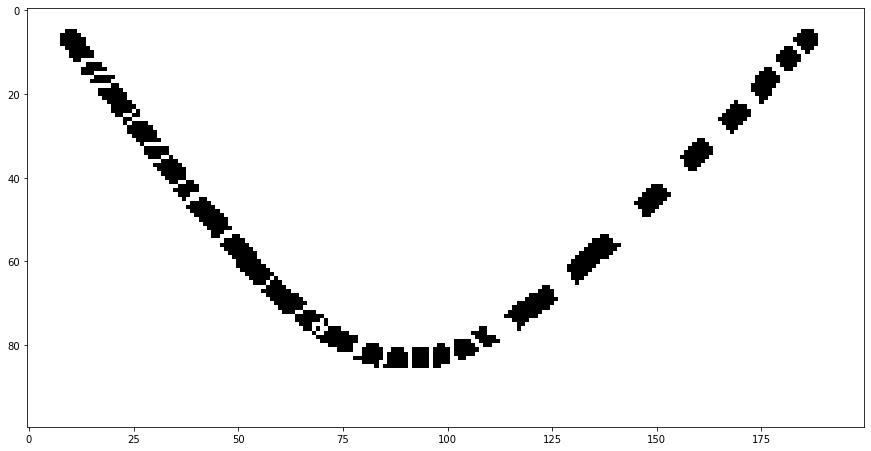

In [14]:
img = cv2.imread('fig/pixel.png',0)
trh, imgBin=cv2.threshold(img, 100, 1, cv2.THRESH_BINARY_INV)
plt.figure(1, figsize=[15,15])
plt.imshow(imgBin,cmap='gray_r')

<h1>Dilatación Direccional</h1>

Para realizar la dilatación direccional se usan tres funciones, la primera aisla los objetos basada en la funciones findContours y drawContours de OpenCv. La segunda función calcula el centroide de un contorno basandose en los momentos y finalmente se usa contourArea para encontrar el area del contorno.

In [4]:
def isolateObject(shape, contours, n):
    newImg=np.ones(shape)*255
    cv2.drawContours(newImg, contours, n, 0, thickness=cv2.FILLED)
    trh, newImgBin=cv2.threshold(newImg, 100, 1, cv2.THRESH_BINARY_INV)
    return newImgBin

def calcCentroid(contour):
    M = cv2.moments(contour)
    cx = int(M['m01']/M['m00'])
    cy = int(M['m10']/M['m00'])
    return (cx,cy)

A continuacion se muestran algunos de los objetos aislados con su centroide y area.

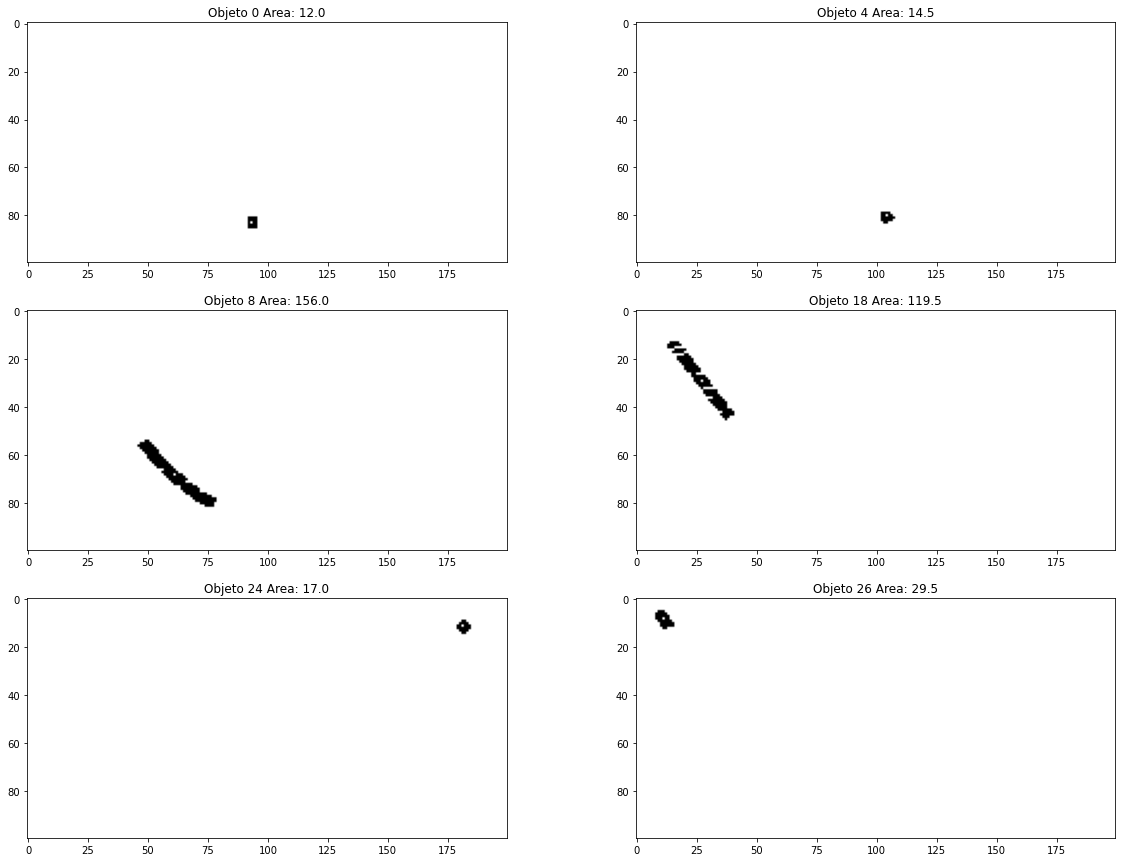

In [7]:
plt.figure(1,figsize=[20,5*3])
contours, hierarchy = cv2.findContours(imgBin,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
n=len(contours)
cont=0
for i in [0, 4, 8, 18, 24, 26]:
    obj1=isolateObject(imgBin.shape, contours, i)
#     obj1=dilateDirection(obj1, 1, 10)
    M = cv2.moments(contours[i])
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    obj1[cy,cx]=0
    plt.subplot(3,2,cont+1)
    plt.imshow(obj1, cmap='gray_r')
    plt.title("Objeto {} Area: {}".format(i,cv2.contourArea(contours[i])))
    cont+=1

Para realizar la dilatación en una dirección se define la función dilateDirection(img, direction, D) que recibe la image, y la dilata en la dirección con una "fuerza" D. La dirección 0 es hacia abajo y aumeta en un sentido antihorario hasta la dirección 7. La función directionaDilation(inputImg, alpha) recibe una image y realiza una dilatación direccional, con el parámetro alpha que controla la relación de la distancia y la fuerza de atracción entre los objetos. En primer lugar ses encuentran los contornos, centroides y areas de cada objeto. Luego calcula la fuerza de crecimiento de cada objeto en cada dirección teniendo en cuenta a todos los demás, finalmente se dilata cada objeto las veces requeridas en cada dirección.

Como ejemplo se muestra la imagen de prueba que despues de la dilatación cerró todos los espacios vacios, formando una trayectoria continua.

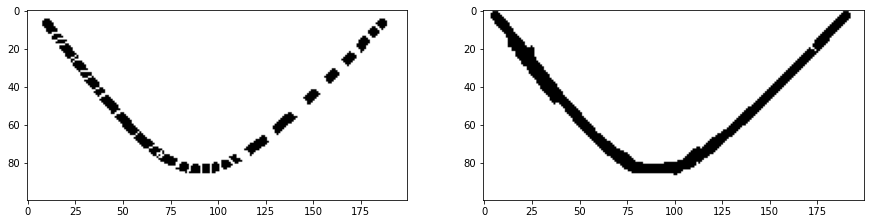

In [11]:
def dilateDirection(img, direction, D):
    direction=direction+4
    kernel=np.zeros((3,3), np.uint8)
    kernel[1,1]=1
    kernel[round(np.cos(direction*np.pi/4))+1,round(np.sin(direction*np.pi/4))+1]=1
    return cv2.dilate(img, kernel, iterations=np.floor(D/0.25).astype(int))

def directionaDilation(inputImg, alpha):    
    trh, imgBin=cv2.threshold(img, 100, 1, cv2.THRESH_BINARY_INV)
    
    contours, hierarchy = cv2.findContours(imgBin,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
    
    centroids=list(map(calcCentroid,contours))
    areas=list(map(cv2.contourArea, contours))
    
    n=len(contours)
    
    outputImg=np.zeros(inputImg.shape)
    
    for i in range(n):
        obj=isolateObject(inputImg.shape, contours, i)
        D=np.zeros(8, np.uint8)
        for j in range(n):
            if i!=j:
                a=centroids[i]
                b=centroids[j]
                
                currAngle=np.angle((a[0]-b[0])+(a[1]-b[1])*1j)*(180/np.pi)
                currAngle=currAngle+(np.less(currAngle,0))*360
                currDist=distance.euclidean(a, b)
                currArea=areas[i]*areas[j]
                
                force=currArea*np.exp(-(np.power(currDist/alpha,2)))
                
                currDir=np.floor((((currAngle-22.5)/45)+1)%8).astype(int)
                D[currDir]=D[currDir]+force
        if(np.max(D)>0):
            D=(D/np.max(D))
        for w in range(8):
            dilate = dilateDirection(obj, w, D[w])   
            outputImg=outputImg+dilate
    return np.clip(outputImg, 0, 1)
plt.figure(2, figsize=[15,20])
plt.subplot(121)
plt.imshow(imgBin, cmap='gray_r')
plt.subplot(122)
plt.imshow(directionaDilation(img, 10), cmap='gray_r')

<h1>Adelgazamiento morfológico</h1>

Para el adelgazamiento se define la función hitMiss que realiza la transformada de una imagen con un kernel dado, añade bordes a la imagen con copyBorder y luego evalua la transformación morfológica con morphologyEx. Tambien se define thinning(A, B) que retorna A adelgazado B.
Para el adelgazamiento simétrico se implementa symmThin(A,i) que adelgaza A en i iteraciones cambiando la dirección del kernel.

Para la demostración se usa el resultado la dilatación del punto anterior y la imagen original. Se muestra la dilatación y luego el adelgazamiento de cada una, se puede ver como al adelgazar la imagen original solo quedan pequeñas trayectorias separadas de un pixel a manera de esqueleto. En cambio despues de la dilatación direccional se puede ver como estas trayectorias separadas se convierten en una sola bien definida.

Text(0.5, 1.0, 'Imagen dilatada y adelgazada')

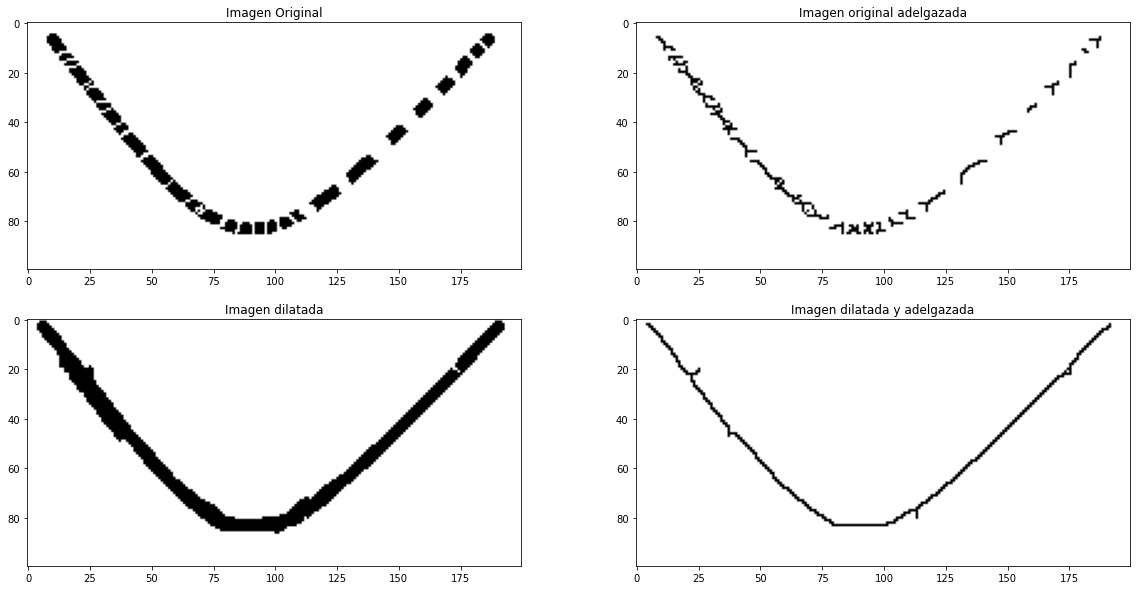

In [9]:
def hitMiss(img, kernel):
    imgBorder=img.copy()
    imgBorder=cv2.copyMakeBorder(imgBorder,1,1,1,1, borderType=cv2.BORDER_CONSTANT)
    out=cv2.morphologyEx(imgBorder, cv2.MORPH_HITMISS, kernel)
    return out[1:imgBorder.shape[0]-1,1:imgBorder.shape[1]-1]

def thinning(A, B):
    C=hitMiss(A, B)
    C=np.equal(C,0)*1
    return np.array(C*A, dtype=np.uint8)

def symmThin(A, i):
    finish=False
    direction=0
    old=A.copy()
    while True:
        kernel=np.ones((3,3), int)*-1
        kernel[1,1]=1
        kernel[round(np.cos(-direction*np.pi/4))+1,round(np.sin(-direction*np.pi/4))+1]=1
        kernel[round(np.cos(-direction*np.pi/4+np.pi/4))+1,round(np.sin(-direction*np.pi/4+np.pi/4))+1]=1
        kernel[round(np.cos(-direction*np.pi/4-np.pi/4))+1,round(np.sin(-direction*np.pi/4-np.pi/4))+1]=1
        kernel[round(np.cos(-direction*np.pi/4+np.pi/2))+1,round(np.sin(-direction*np.pi/4+np.pi/2))+1]=0
        kernel[round(np.cos(-direction*np.pi/4-np.pi/2))+1,round(np.sin(-direction*np.pi/4-np.pi/2))+1]=0
        
        new=thinning(old, kernel)
        
        if direction>i:
            return new
        else:
            direction=direction+1
            old=new.copy()
dilatedImg=np.array(directionaDilation(imgBin, 10), dtype=np.uint8)
originalThin=symmThin(imgBin,100)
thin=symmThin(dilatedImg,100)
plt.figure(1, figsize=[20,10])

plt.subplot(2,2,1)
plt.imshow(imgBin, cmap='gray_r')
plt.title("Imagen Original")

plt.subplot(2,2,2)
plt.imshow(originalThin, cmap='gray_r')
plt.title("Imagen original adelgazada")

plt.subplot(2,2,3)
plt.imshow(dilatedImg, cmap='gray_r')
plt.title("Imagen dilatada")

plt.subplot(2,2,4)
plt.imshow(thin, cmap='gray_r')
plt.title("Imagen dilatada y adelgazada")

Adicionalmente para comprobar el funcionamiento del algoritmo de adelgazamiento simétrico se usa la imagen ejemplo de la clase. Efectivamente se puede ver como se reduce la imagen original a su "esqueleto".

Text(0.5, 1.0, 'Imagen adelgazada')

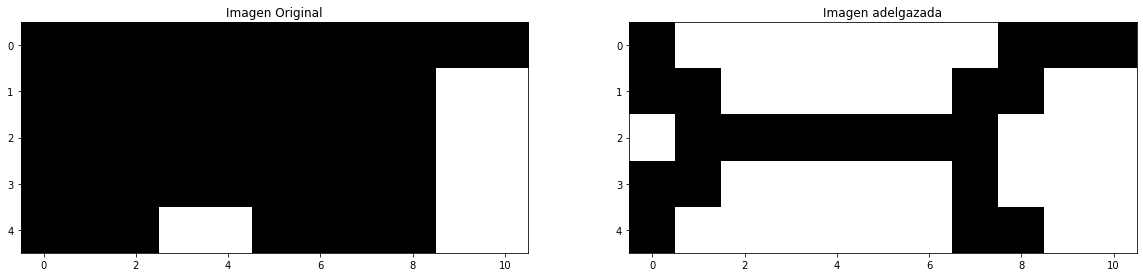

In [10]:
img2 = cv2.imread('fig/pixelDog.png',0)
trh, imgBin2=cv2.threshold(img2, 100, 1, cv2.THRESH_BINARY_INV)
thin2=symmThin(imgBin2, 100)
plt.figure(1, figsize=[20,10])

plt.subplot(1,2,1)
plt.imshow(imgBin2, cmap='gray_r')
plt.title("Imagen Original")

plt.subplot(1,2,2)
plt.imshow(thin2, cmap='gray_r')
plt.title("Imagen adelgazada")